In [4]:
import numpy as np
import scipy
import sympy as sym
import matplotlib.pyplot as plt
import cv2
from sklearn.cluster import KMeans
from IPython.display import display

In [5]:
world_points = [
    [-1.5, -1.5],
    [-1.5, 0.5],
    [-0.5, -0.5],
    [-0.5, 1.5],
    [0.5, -1.5],
    [0.5, 0.5],
    [1.5, -0.5],
    [1.5, 1.5],
]

world_points = np.array(world_points)
world_points /=2
display(world_points)

# test:
# plt.scatter(world_points[:, 0], world_points[:, 1], c="r", s=10);

array([[-0.75, -0.75],
       [-0.75,  0.25],
       [-0.25, -0.25],
       [-0.25,  0.75],
       [ 0.25, -0.75],
       [ 0.25,  0.25],
       [ 0.75, -0.25],
       [ 0.75,  0.75]])

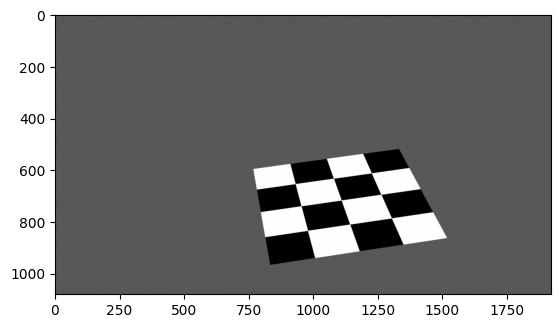

In [6]:
camera_index = 3
# read from camera_i.png:
img = cv2.imread('imgs/camera_'+str(camera_index)+'.png', cv2.IMREAD_GRAYSCALE)
# test if the image is read correctly:
plt.imshow(img, cmap='gray');

(1080, 1920)


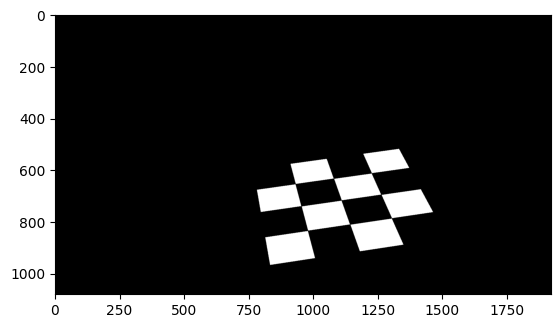

In [7]:
# seprate into two images, <50 and >100:
black_img = np.zeros_like(img)
black_img[img < 50] = 255

print(black_img.shape)

plt.imshow(black_img, cmap='gray');

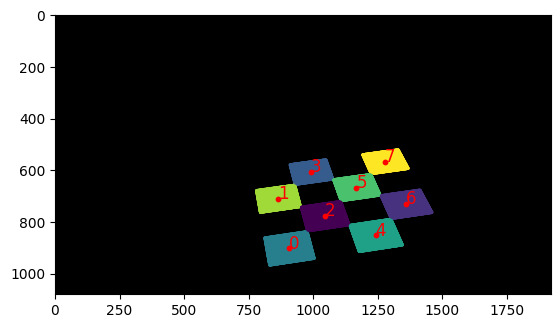

In [8]:
black_img_points = np.argwhere(black_img == 255)

kmenas = KMeans(n_clusters=8, random_state=0).fit(black_img_points)
centers = kmenas.cluster_centers_

# manually map the centers to the world points, which isn't ideal:
mappings = {
    1: {
        0: 3,
        1: 6,
        2: 0,
        3: 7,
        4: 4,
        5: 1,
        6: 5,
        7: 2,
    },
    2: {
        0: 0,
        1: 6,
        2: 2,
        3: 4,
        4: 5,
        5: 1,
        6: 7,
        7: 3,
    },
    3: {
        0: 3,
        1: 6,
        2: 0,
        3: 2,
        4: 4,
        5: 5,
        6: 1,
        7: 7,
    },
}

# apply mappings[i]:
mapping = mappings[camera_index]
centers = centers[[mapping[j] for j in range(8)]]

plt.imshow(black_img, cmap="gray")
plt.scatter(black_img_points[:, 1], black_img_points[:, 0], c=kmenas.labels_, s=1)
# label the centers:
for camera_index in range(centers.shape[0]):
    plt.text(
        centers[camera_index, 1],
        centers[camera_index, 0],
        str(camera_index),
        fontsize=12,
        color="red",
    )
plt.scatter(centers[:, 1], centers[:, 0], c="r", s=10)
plt.gca().set_aspect("equal", adjustable="box")

In [9]:
alpha = sym.Symbol("\\alpha")
beta = sym.Symbol("\\beta")
gamma = sym.Symbol("\\gamma")
Tx = sym.Symbol("T_x")
Ty = sym.Symbol("T_y")
Tz = sym.Symbol("T_z")
Ralpha = sym.Matrix(
    [
        [1, 0, 0],
        [0, sym.cos(alpha), -sym.sin(alpha)],
        [0, sym.sin(alpha), sym.cos(alpha)],
    ]
)
Rbeta = sym.Matrix(
    [
        [sym.cos(beta), 0, sym.sin(beta)],
        [0, 1, 0],
        [-sym.sin(beta), 0, sym.cos(beta)],
    ]
)
Rgamma = sym.Matrix(
    [
        [sym.cos(gamma), -sym.sin(gamma), 0],
        [sym.sin(gamma), sym.cos(gamma), 0],
        [0, 0, 1],
    ]
)
R = Ralpha * Rbeta * Rgamma
display(R)
T = sym.Matrix([[Tx], [Ty], [Tz]])
f = sym.Symbol("f")
K = sym.Matrix([[f, 0, 0], [0, f, 0], [0, 0, 1]])
P = K * sym.Matrix.hstack(R, T)
display(P)
Xw = sym.Symbol("X_w")
Yw = sym.Symbol("Y_w")
Zw = sym.Symbol("Z_w")
u = sym.Symbol("u")
v = sym.Symbol("v")
_eq = P * sym.Matrix([[Xw], [Yw], [Zw], [1]])
display(_eq)
eq_u = _eq[0] - u * _eq[2]
eq_v = _eq[1] - v * _eq[2]
eq = sym.Matrix([eq_u, eq_v])
display(eq)
eq_jacobi = eq.jacobian([alpha, beta, gamma, Tx, Ty, Tz])
display(eq_jacobi)

Matrix([
[                                      cos(\beta)*cos(\gamma),                                       -sin(\gamma)*cos(\beta),              sin(\beta)],
[sin(\alpha)*sin(\beta)*cos(\gamma) + sin(\gamma)*cos(\alpha), -sin(\alpha)*sin(\beta)*sin(\gamma) + cos(\alpha)*cos(\gamma), -sin(\alpha)*cos(\beta)],
[sin(\alpha)*sin(\gamma) - sin(\beta)*cos(\alpha)*cos(\gamma),  sin(\alpha)*cos(\gamma) + sin(\beta)*sin(\gamma)*cos(\alpha),  cos(\alpha)*cos(\beta)]])

Matrix([
[                                        f*cos(\beta)*cos(\gamma),                                         -f*sin(\gamma)*cos(\beta),              f*sin(\beta), T_x*f],
[f*(sin(\alpha)*sin(\beta)*cos(\gamma) + sin(\gamma)*cos(\alpha)), f*(-sin(\alpha)*sin(\beta)*sin(\gamma) + cos(\alpha)*cos(\gamma)), -f*sin(\alpha)*cos(\beta), T_y*f],
[    sin(\alpha)*sin(\gamma) - sin(\beta)*cos(\alpha)*cos(\gamma),      sin(\alpha)*cos(\gamma) + sin(\beta)*sin(\gamma)*cos(\alpha),    cos(\alpha)*cos(\beta),   T_z]])

Matrix([
[                                                                                             T_x*f + X_w*f*cos(\beta)*cos(\gamma) - Y_w*f*sin(\gamma)*cos(\beta) + Z_w*f*sin(\beta)],
[T_y*f + X_w*f*(sin(\alpha)*sin(\beta)*cos(\gamma) + sin(\gamma)*cos(\alpha)) + Y_w*f*(-sin(\alpha)*sin(\beta)*sin(\gamma) + cos(\alpha)*cos(\gamma)) - Z_w*f*sin(\alpha)*cos(\beta)],
[         T_z + X_w*(sin(\alpha)*sin(\gamma) - sin(\beta)*cos(\alpha)*cos(\gamma)) + Y_w*(sin(\alpha)*cos(\gamma) + sin(\beta)*sin(\gamma)*cos(\alpha)) + Z_w*cos(\alpha)*cos(\beta)]])

Matrix([
[                                                                                             T_x*f + X_w*f*cos(\beta)*cos(\gamma) - Y_w*f*sin(\gamma)*cos(\beta) + Z_w*f*sin(\beta) - u*(T_z + X_w*(sin(\alpha)*sin(\gamma) - sin(\beta)*cos(\alpha)*cos(\gamma)) + Y_w*(sin(\alpha)*cos(\gamma) + sin(\beta)*sin(\gamma)*cos(\alpha)) + Z_w*cos(\alpha)*cos(\beta))],
[T_y*f + X_w*f*(sin(\alpha)*sin(\beta)*cos(\gamma) + sin(\gamma)*cos(\alpha)) + Y_w*f*(-sin(\alpha)*sin(\beta)*sin(\gamma) + cos(\alpha)*cos(\gamma)) - Z_w*f*sin(\alpha)*cos(\beta) - v*(T_z + X_w*(sin(\alpha)*sin(\gamma) - sin(\beta)*cos(\alpha)*cos(\gamma)) + Y_w*(sin(\alpha)*cos(\gamma) + sin(\beta)*sin(\gamma)*cos(\alpha)) + Z_w*cos(\alpha)*cos(\beta))]])

Matrix([
[                                                                                                                                                                              -u*(X_w*(sin(\alpha)*sin(\beta)*cos(\gamma) + sin(\gamma)*cos(\alpha)) + Y_w*(-sin(\alpha)*sin(\beta)*sin(\gamma) + cos(\alpha)*cos(\gamma)) - Z_w*sin(\alpha)*cos(\beta)),                                    -X_w*f*sin(\beta)*cos(\gamma) + Y_w*f*sin(\beta)*sin(\gamma) + Z_w*f*cos(\beta) - u*(-X_w*cos(\alpha)*cos(\beta)*cos(\gamma) + Y_w*sin(\gamma)*cos(\alpha)*cos(\beta) - Z_w*sin(\beta)*cos(\alpha)),                                                                                  -X_w*f*sin(\gamma)*cos(\beta) - Y_w*f*cos(\beta)*cos(\gamma) - u*(X_w*(sin(\alpha)*cos(\gamma) + sin(\beta)*sin(\gamma)*cos(\alpha)) + Y_w*(-sin(\alpha)*sin(\gamma) + sin(\beta)*cos(\alpha)*cos(\gamma))), f, 0, -u],
[X_w*f*(-sin(\alpha)*sin(\gamma) + sin(\beta)*cos(\alpha)*cos(\gamma)) + Y_w*f*(-sin(\alpha)*cos(\gamma) - sin(\bet

In [10]:
display(world_points)
display(centers)
display(img.shape)

array([[-0.75, -0.75],
       [-0.75,  0.25],
       [-0.25, -0.25],
       [-0.25,  0.75],
       [ 0.25, -0.75],
       [ 0.25,  0.25],
       [ 0.75, -0.25],
       [ 0.75,  0.75]])

array([[ 901.96897672,  905.71364375],
       [ 709.74087863,  863.45778109],
       [ 777.3379369 , 1043.92859013],
       [ 606.49487046,  991.04877413],
       [ 851.6825065 , 1241.27087807],
       [ 666.48134097, 1166.99465779],
       [ 731.24041507, 1359.0310626 ],
       [ 566.44998217, 1277.77309201]])

(1080, 1920)

In [11]:
def transform_u(u_) -> float:
    return (u_ - img.shape[1] / 2) / img.shape[1] * 36e-3


def transform_v(v_) -> float:
    return (img.shape[0] / 2 - v_) / img.shape[0] * 36e-3 * 9 / 16


def calc(x):
    alpha_, beta_, gamma_, Tx_, Ty_, Tz_ = x
    # return a 16x1 vector, plug in the values of alpha, beta, gamma, Tx, Ty, Tz tp eq:
    f_ = 50e-3
    PAD = 0
    COUNT = 3
    return np.array(
        [
            eq_u.subs(
                {
                    alpha: alpha_,
                    beta: beta_,
                    gamma: gamma_,
                    Tx: Tx_,
                    Ty: Ty_,
                    Tz: Tz_,
                    Xw: world_points[i // 2, 0],
                    Yw: world_points[i // 2, 1],
                    Zw: 0,
                    u: transform_u(centers[i // 2, 1]),
                    f: f_,
                }
            )
            for i in range(PAD, PAD + COUNT * 2)
        ],
        dtype=np.float64,
    )


# calc(sym.pi / 2, 0, 0, 4, 0, 0)
# use scipy to solve the equation:
res = scipy.optimize.fsolve(calc, [0, 0, 0, 0, 0, 0])
print(res)

[-4.04494258e+01  7.29146548e+00  1.02827280e-01  2.65111431e-01
  2.12692992e-02  4.71411004e+00]
